In [1]:
# Neccessary libraries
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

# Implementation of Xception Model

In [2]:
models = tf.contrib.keras.models
layers = tf.contrib.keras.layers
utils = tf.contrib.keras.utils
losses = tf.contrib.keras.losses
optimizers = tf.contrib.keras.optimizers 
metrics = tf.contrib.keras.metrics
preprocessing_image = tf.contrib.keras.preprocessing.image
applications = tf.contrib.keras.applications

In [3]:
# Convolution Block
def conv_block(x, filters, block_num, conv_num, strides=(1,1)):
    name = 'block{}_conv{}_'.format(block_num, conv_num)
    
    # conv-BN-relu
    x = layers.Conv2D(filters, (3,3), strides=(2,2), use_bias=False, name=name)(x)
    x = layers.BatchNormalization(name=name+'bn')(x)
    x = layers.Activation('relu', name=name+'act')(x)

    return x

In [4]:
# Separable Convolution Block
def separable_conv_block(x, filters, block_num, conv_num, pre_activation=None):
    name = 'block{}_sepconv{}_'.format(block_num, conv_num)

    if pre_activation is True:
        x = layers.Activation('relu', name=name+'act')(x)
        
    # (relu)-sepconv-BN-(relu)
    x = layers.SeparableConv2D(filters, (3,3), padding='same', use_bias=False, name=name)(x)
    x = layers.BatchNormalization(name=name+'bn')(x)
    
    if pre_activation is False:
        x = layers.Activation('relu', name=name+'act')(x)
    

    return x

In [5]:
def middle_flow_block(x, filters, block_num):

    # middle flow
    
    residual = x
    
    x = separable_conv_block(x, filters, block_num=block_num, conv_num='1', pre_activation=True)
    x = separable_conv_block(x, filters, block_num=block_num, conv_num='2', pre_activation=True)
    x = separable_conv_block(x, filters, block_num=block_num, conv_num='3', pre_activation=True)
    
    return layers.add([x, residual])

In [6]:
def xception_block(x, filters, block_num, pre_activation=True):
    block = 'block{}_'.format(block_num)
    filter_conv1, filter_conv2 = filters

    # residual conv branch
    residual = layers.Conv2D(filter_conv2, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
    residual = layers.BatchNormalization()(residual)

    # separable conv block
    x = separable_conv_block(x, filter_conv1, block_num=block_num, conv_num='1', pre_activation=pre_activation)
    x = separable_conv_block(x, filter_conv2, block_num=block_num, conv_num='2', pre_activation=True)

    # downsampling and merging
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same', name=block+'pool')(x)
    
    return layers.add([x, residual])

# Full Xception Model

In [9]:
def Xception(input_shape=(299,299,3), classes=1000):
    """Instantiates the Xception architecture.
    """
    
    img_input = layers.Input(shape=input_shape)

    #===========ENTRY FLOW==============
    #Block 1
    x = conv_block(img_input, 32, block_num='1', conv_num='1', strides=(2,2))
    x = conv_block(x, 64, block_num='1', conv_num='2')

    #Block 2
    x = xception_block(x, (128, 128), '2', pre_activation=False)

    #Block 3
    x = xception_block(x, (256, 256), '3')

    #Block 4
    x = xception_block(x, (728, 728), '4')
         

    #===========MIDDLE FLOW===============
    for i in range(8):
        block_num = str(5+i)
        x = middle_flow_block(x, 728, block_num)

    #========EXIT FLOW============
    #Block 13
    x = xception_block(x, (728, 1024), '13') # second conv is different

    # Block 14
    x = separable_conv_block(x, 1536, block_num='14', conv_num='1', pre_activation=False)
    x = separable_conv_block(x, 2048, block_num='14', conv_num='2', pre_activation=False)

    # logistic regression
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = layers.Dense(classes, activation='softmax', name='predictions')(x)

    # Create model.
    model = models.Model(inputs=img_input, outputs=x, name='xception')
    return model

In [10]:
xception = Xception()
xception.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1_ (Conv2D)          (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1_[0][0]              
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

# Training and Evaluating Xception Model

In [11]:
# load pre-trained Xception model and exclude top dense layer
base_model = applications.Xception(include_top=False,
                                   weights='imagenet',
                                   input_shape=(299,299,3),
                                   pooling='avg')

83689472/83683744 [==============================] - 171s 2us/step


In [12]:
print("Model input shape: {}\n".format(base_model.input_shape))
print("Model output shape: {}\n".format(base_model.output_shape))
print("Model number of layers: {}\n".format(len(base_model.layers)))

Model input shape: (None, 299, 299, 3)

Model output shape: (None, 2048)

Model number of layers: 133



# Fine-tune Xception Model

In [13]:
def fine_tune_Xception(base_model):
    
    # output of convolutional layers
    x = base_model.output

    # final Dense layer
    outputs = layers.Dense(4, activation='softmax')(x)

    # define model with base_model's input
    model = models.Model(inputs=base_model.input, outputs=outputs)
    
    # freeze weights of early layers
    # to ease training
    for layer in model.layers[:40]:
        layer.trainable = False
    
    return model

In [14]:
def compile_model(model):
    
    # loss
    loss = losses.categorical_crossentropy
    
    # optimizer
    optimizer = optimizers.RMSprop(lr=0.0001)
    
    # metrics
    metric = [metrics.categorical_accuracy]
    
    # compile model with loss, optimizer, and evaluation metrics
    model.compile(optimizer, loss, metric)
        
    return model

In [15]:
model = fine_tune_Xception(base_model)
model = compile_model(model)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

# Image Preprocessing And Augmentation

In [16]:
def preprocess_image(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    
    # 'RGB'->'BGR'
    x = x[..., ::-1]
    # Zero-center by mean pixel
    x[..., 0] -= 103.939
    x[..., 1] -= 116.779
    x[..., 2] -= 123.68
    return x


train_datagen = preprocessing_image.ImageDataGenerator(
    preprocessing_function=preprocess_image,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = preprocessing_image.ImageDataGenerator(preprocessing_function=preprocess_image)

In [17]:
BASE_DIR = "ImageNet_Utils"

train_generator = train_datagen.flow_from_directory(
    os.path.join(BASE_DIR, "imageNet_dataset/train"),
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=True)

validation_generator = test_datagen.flow_from_directory(
    os.path.join(BASE_DIR, "imageNet_dataset/validation"),
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=True)

Found 2636 images belonging to 4 classes.
Found 985 images belonging to 4 classes.


# Train Model on ImageNet Dataset

In [18]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=80,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=20)

Epoch 1/10
80/80 [==============================] - 169s 2s/step - loss: 0.2231 - categorical_accuracy: 0.9470 - val_loss: 11.9878 - val_categorical_accuracy: 0.2562
Epoch 2/10
80/80 [==============================] - 45s 557ms/step - loss: 0.0546 - categorical_accuracy: 0.9855 - val_loss: 11.9878 - val_categorical_accuracy: 0.2562
Epoch 3/10
80/80 [==============================] - 44s 548ms/step - loss: 0.0219 - categorical_accuracy: 0.9930 - val_loss: 11.9878 - val_categorical_accuracy: 0.2562
Epoch 4/10
80/80 [==============================] - 44s 546ms/step - loss: 0.0095 - categorical_accuracy: 0.9965 - val_loss: 8.7138 - val_categorical_accuracy: 0.4594
Epoch 5/10
80/80 [==============================] - 44s 546ms/step - loss: 0.0124 - categorical_accuracy: 0.9965 - val_loss: 7.6738 - val_categorical_accuracy: 0.2562
Epoch 6/10
80/80 [==============================] - 44s 547ms/step - loss: 0.0065 - categorical_accuracy: 0.9980 - val_loss: 8.7138 - val_categorical_accuracy: 0.45

# Plot Accuracy And Loss Over Time

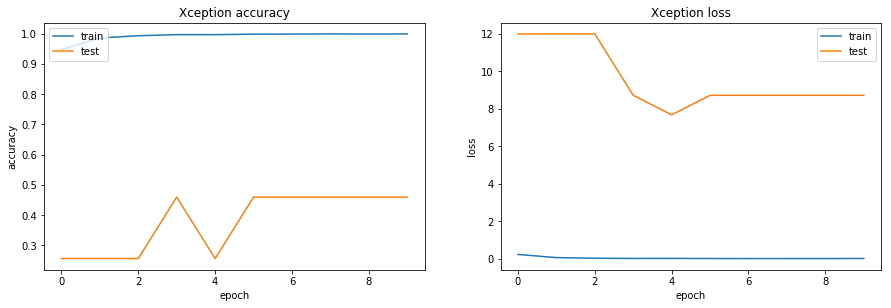

In [19]:
def plot_accuracy_and_loss(history):
    plt.figure(1, figsize= (15, 10))
    
    # plot train and test accuracy
    plt.subplot(221)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Xception accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # plot train and test loss
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Xception loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    
    plt.plt.savefig("Xception.jpg")
    plt.show()
    
plot_accuracy_and_loss(history)

# Save Model Weights And Configuration

In [20]:
# save model architecture
model_json = model.to_json()
open('xception_model.json', 'w').write(model_json)

# save model's learned weights
model.save_weights('image_classifier_xception.h5', overwrite=True)